# 1. Modeling Volatility and VaR

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

original_df = pd.read_excel(r'../data/barnstable_analysis_data.xlsx',sheet_name='data')
# original_df.head()
# original_df.tail()
original_df.index = original_df['date']
original_df.drop(columns=['date'], inplace=True)
level_er_mo = original_df['SPX'].mean() - original_df['TB1M'].mean()
level_er_yr = level_er_mo * 12
level_er_yr

0.0823357917288515

## 1. Historic VaR

In [118]:
original_df

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033296,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691
...,...,...
2023-04-28,0.015015,0.003475
2023-05-31,0.005306,0.004129
2023-06-30,0.066952,0.004302


In [119]:
confidence_level = 0.95  # 95% confidence level

rolling_vars = []  # To store the rolling VaR values
start_t = 60
for i in range(start_t,len(original_df)):
    # Calculate rolling VaR for the available data up to the current date
    spx_rolling_data = original_df['SPX'].iloc[:i]  # Slice the data up to the current date
    spx_var = np.percentile(spx_rolling_data, 100 * (1 - confidence_level))
    tb1m_rolling_data = original_df['TB1M'].iloc[:i]
    tb1m_var = np.nanpercentile(tb1m_rolling_data,100 * (1-confidence_level))
    rolling_vars.append([spx_var, tb1m_var])

# Create a new DataFrame with the rolling VaR values
rolling_var_df = pd.DataFrame(rolling_vars, columns=['SPX (VaR 0.05)', 'TB1M (VaR 0.05)'], index=original_df.index[start_t:])

rolling_var_df


,SPX (VaR 0.05),TB1M (VaR 0.05)
date,,
1931-01-31,-0.123639,0.001232
1931-02-28,-0.123548,0.001183
1931-03-31,-0.121555,0.001185
1931-04-30,-0.119562,0.001126
1931-05-29,-0.118960,0.001046
...,...,...
2023-04-28,-0.077321,0.000013
2023-05-31,-0.077277,0.000013
2023-06-30,-0.077232,0.000013


### a. Plot VaR

<Axes: xlabel='date'>

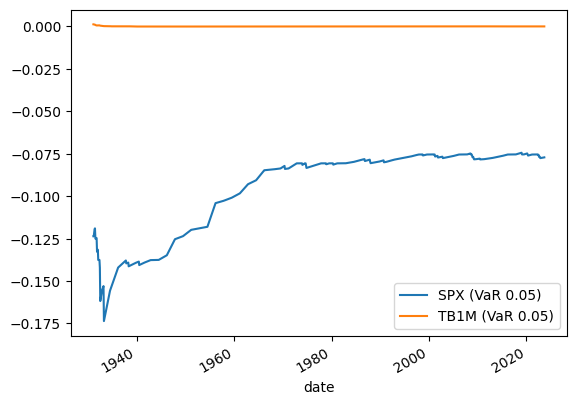

In [120]:
rolling_var_df.plot(y=['SPX (VaR 0.05)', 'TB1M (VaR 0.05)'])

### b. Calculate the frequency of periods in which actual return < VaR 0.05

In [121]:

df_er_var = pd.concat([original_df.iloc[start_t:,:], rolling_var_df], axis=1)
df_er_var['ER < VaR (SPX)'] = df_er_var['SPX'] < df_er_var["SPX (VaR 0.05)"]
df_er_var['ER < VaR (TB1M)'] = df_er_var['TB1M'] < df_er_var["TB1M (VaR 0.05)"]
var_performance = df_er_var[['ER < VaR (SPX)', 'ER < VaR (TB1M)']].agg(['sum']).T
var_performance['pct correct'] = var_performance['sum']/df_er_var.shape[0]
var_performance

,sum,pct correct
ER < VaR (SPX),36,0.032374
ER < VaR (TB1M),107,0.096223


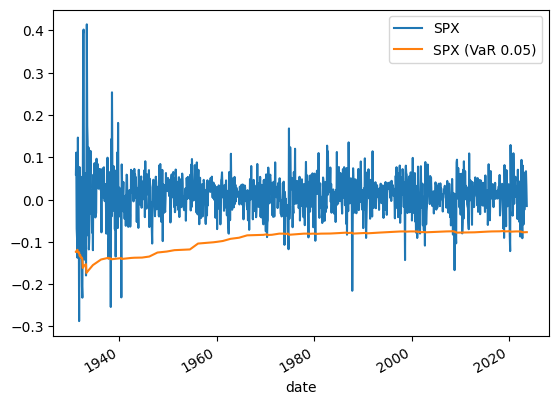

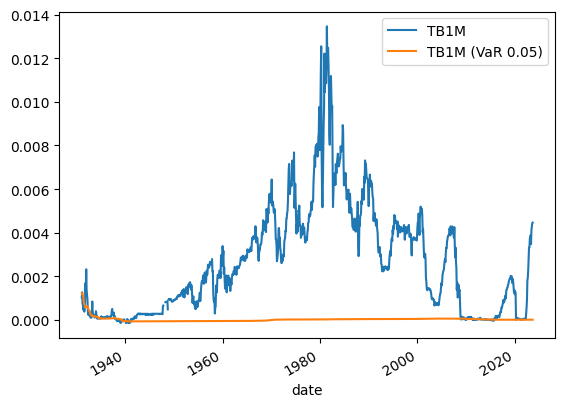

In [122]:
plots = [['SPX', 'SPX (VaR 0.05)'], ['TB1M', 'TB1M (VaR 0.05)']]
for plot in plots:
    df_er_var.plot(y=plot)

### c. What drawbacks do you see in teh historic Var?

It has some variation in its ability to predict the future as with any other sample statistic. We used a Var of 5% but we can see that the actual accuracy of the VaR was exceeded only 3.2% of the time for SPX and was exceeded almost 10% of the time by TB1M. So the VaR statistic tells us about the VaR from the past but may not be a great predictor of future VaR. 

## 2. Volatility

### a. Expanding Series

In [123]:
rolling_vols = []  # To store the rolling VaR values
start_t = 60
for i in range(start_t,len(original_df)):
    # Calculate rolling VaR for the available data up to the current date
    spx_rolling_data = original_df['SPX'].iloc[:i]  # Slice the data up to the current date
    spx_vol = spx_rolling_data.std()
    tb1m_rolling_data = original_df['TB1M'].iloc[:i]
    tb1m_vol = tb1m_rolling_data.std()
    
    rolling_vols.append([spx_vol, tb1m_vol])

# Create a new DataFrame with the rolling VaR values
expanding_vol_df = pd.DataFrame(rolling_vols, columns=['SPX (Expanding Vol)', 'TB1M (Expanding Vol)'], index=original_df.index[start_t:])

expanding_vol_df

,SPX (Expanding Vol),TB1M (Expanding Vol)
date,,
1931-01-31,0.060670,0.000830
1931-02-28,0.060526,0.000855
1931-03-31,0.061419,0.000870
1931-04-30,0.061733,0.000901
1931-05-29,0.062553,0.000931
...,...,...
2023-04-28,0.054141,0.002468
2023-05-31,0.054118,0.002467
2023-06-30,0.054095,0.002467


#### a. Plot Volatility

<Axes: xlabel='date'>

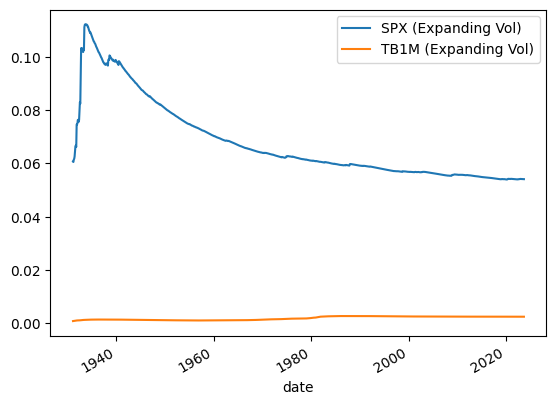

In [124]:
expanding_vol_df.plot(y=expanding_vol_df.columns)

#### b. %th Pctl, 1 mo ahead VaR

In [125]:
# Create a DataFrame with the sample data
# original_df = pd.DataFrame(data)

# Initialize a list to store the rolling VaR values
rolling_vols = []

start_t = 60  # Start at time t = 60

for i in range(start_t, len(expanding_vol_df)):
    # Calculate rolling VaR for SPX (Expanding Vol)
    spx_rolling_data = expanding_vol_df['SPX (Expanding Vol)'].iloc[i - start_t:i]
    spx_vol_var = spx_rolling_data.std() * -1.65  # You can adjust the multiplier as needed
    spx_95pct_vol = np.percentile(spx_vol_var, 5)
    
    # Calculate rolling VaR for TB1M (Expanding Vol)
    tb1m_rolling_data = expanding_vol_df['TB1M (Expanding Vol)'].iloc[i - start_t:i]
    tb1m_vol_var = tb1m_rolling_data.std() * -1.65  # You can adjust the multiplier as needed
    tb1m_95pct_vol = np.percentile(tb1m_vol_var, 5)
    
    rolling_vols.append([spx_vol_var, spx_95pct_vol, tb1m_vol_var, tb1m_95pct_vol])

# Create a new DataFrame with the rolling VaR values
expanding_vol_df = pd.DataFrame(rolling_vols, columns=[
    'SPX (Expanding Vol dist) VaR',
    'SPX (Expanding Vol pctl) VaR',
    'TB1M (Expanding Vol dist) VaR',
    'TB1M (Expanding Vol pctl) VaR'
], index=expanding_vol_df.index[start_t:])

expanding_vol_df

,SPX (Expanding Vol dist) VaR,SPX (Expanding Vol pctl) VaR,TB1M (Expanding Vol dist) VaR,TB1M (Expanding Vol pctl) VaR
date,,,,
1936-01-31,-0.029423,-0.029423,-0.000273,-0.000273
1936-02-29,-0.028476,-0.028476,-0.000262,-0.000262
1936-03-31,-0.027436,-0.027436,-0.000251,-0.000251
1936-04-30,-0.026357,-0.026357,-0.000240,-0.000240
1936-05-29,-0.025199,-0.025199,-0.000230,-0.000230
...,...,...,...,...
2023-04-28,-0.000108,-0.000108,-0.000011,-0.000011
2023-05-31,-0.000107,-0.000107,-0.000010,-0.000010
2023-06-30,-0.000106,-0.000106,-0.000010,-0.000010


In [126]:
expanding_vol_df['1mo']

KeyError: '1mo'

### b. Rolling Volatility

In [ ]:
rolling_vol_df = original_df.rolling(window=60).std()
rolling_vol_df.columns = ['SPX (Rolling Vol)', 'TB1M (Rolling Vol)']
rolling_vol_df = rolling_vol_df[60:]

,SPX (Rolling Vol),TB1M (Rolling Vol)
date,,
1931-01-31,0.061022,0.000861
1931-02-28,0.062166,0.000884
1931-03-31,0.062394,0.000922
1931-04-30,0.063706,0.000959
1931-05-29,0.066447,0.001002
...,...,...
2023-04-28,0.053809,0.001163
2023-05-31,0.053785,0.001224
2023-06-30,0.054277,0.001287


<Axes: xlabel='date'>

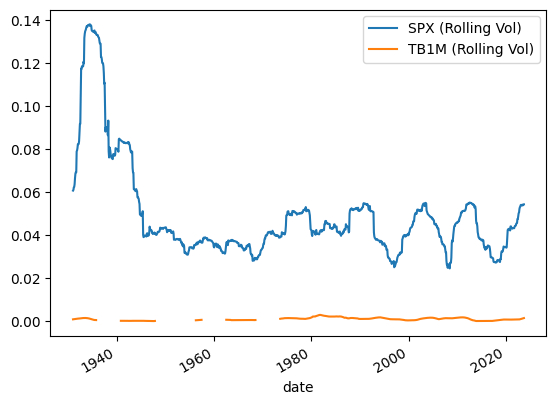

In [ ]:
rolling_vol_df.plot(y=rolling_vol_df.columns)